# Tuning a `multi_match` `most_fields` query

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev_templated, optimize_query_mrr100_templated, set_bm25_params
from qopt.optimize import Config

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://34.89.199.174:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

index = 'msmarco-document.ner'
template_id = 'query'
query_type = 'most_fields'

# set best BM25 params
set_bm25_params(es, index, [
    ('url', {'k1': 0.33066956222950633, 'b': 0.9589101032169087}), # 0.2201
    ('title', {'k1': 0.34885436112727763, 'b': 1.0}), # 0.2354
    ('title.bigrams', {'k1': 1.2, 'b': 0.75}), # 0.1295
    ('body', {'k1': 3.0128735487205525, 'b': 0.8200709176657588}), # 0.2645
    ('body.bigrams', {'k1': 1.9100199633100623, 'b': 0.7336619962002098}), # 0.2045
    ('entities', {'k1': 1.4856968960928536, 'b': 0.3}),
])

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

Setting BM25 params fields:
 - url: {'k1': 0.33066956222950633, 'b': 0.9589101032169087}
 - title: {'k1': 0.34885436112727763, 'b': 1.0}
 - title.bigrams: {'k1': 1.2, 'b': 0.75}
 - body: {'k1': 3.0128735487205525, 'b': 0.8200709176657588}
 - body.bigrams: {'k1': 1.9100199633100623, 'b': 0.7336619962002098}
 - entities: {'k1': 1.4856968960928536, 'b': 0.3}


## Experiments

### Base fields

In [ ]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
    ]
}

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
})

In [ ]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

In [ ]:
_ = plot_objective(metadata, sample_source='result')

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

In [ ]:
final_params

### Base fields + bigrams

In [ ]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
    ]
}

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
})

In [ ]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

In [ ]:
_ = plot_objective(metadata, sample_source='result')

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

In [ ]:
final_params

### Base fields + entities

In [32]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from qopt.trec import load_queries_as_tuple_list, load_qrels
from qopt.notebooks import *

In [48]:
def has_entity(text):
    return ner_uncased(text)


def evaluate_mrr100_dev_notner(es, max_concurrent_searches, index, templates, template_id, params):
    k = 100
    queries = load_queries_as_tuple_list(os.path.join(os.path.abspath('..'), 'data', 'msmarco', 'document', 'msmarco-docdev-queries.tsv'))
    qrels = load_qrels(os.path.join(os.path.abspath('..'), 'data', 'msmarco', 'document', 'msmarco-docdev-qrels.tsv'))

    queries = [x for x in queries if not has_entity(x[1])]
    
    body = {
        'metric': mrr(k),
        'templates': templates,
        'requests': build_requests(index, template_id, queries, qrels, params),
        'max_concurrent_searches': max_concurrent_searches,
    }

    print(f"Evaluation with: MRR@{k}")

    results = es.rank_eval(body=body, index=index, request_timeout=1200,
                           allow_no_indices=False, ignore_unavailable=False,
                           search_type='dfs_query_then_fetch')
    print(f"Score: {results['metric_score']:.04f}")
    return results


def evaluate_mrr100_dev_ner(es, max_concurrent_searches, index, templates, template_id, params):
    k = 100
    queries = load_queries_as_tuple_list(os.path.join(os.path.abspath('..'), 'data', 'msmarco', 'document', 'msmarco-docdev-queries.tsv'))
    qrels = load_qrels(os.path.join(os.path.abspath('..'), 'data', 'msmarco', 'document', 'msmarco-docdev-qrels.tsv'))

    queries = [x for x in queries if has_entity(x[1])]
    
    body = {
        'metric': mrr(k),
        'templates': templates,
        'requests': build_requests(index, template_id, queries, qrels, params),
        'max_concurrent_searches': max_concurrent_searches,
    }

    print(f"Evaluation with: MRR@{k}")

    results = es.rank_eval(body=body, index=index, request_timeout=1200,
                           allow_no_indices=False, ignore_unavailable=False,
                           search_type='dfs_query_then_fetch')
    print(f"Score: {results['metric_score']:.04f}")
    return results


def optimize_query_mrr100_ner(es, max_concurrent_searches, index, templates, template_id, config_space, verbose=True):
    k = 100
    queries_fname = os.path.join(os.path.abspath('..'), 'data', 'msmarco-document-sampled-queries.1000.tsv')
    qrels_fname = os.path.join(os.path.abspath('..'), 'data', 'msmarco', 'document', 'msmarco-doctrain-qrels.tsv')

    queries = load_queries_as_tuple_list(os.path.join(ROOT_DIR, queries_fname))
    qrels = load_qrels(os.path.join(ROOT_DIR, qrels_fname))

    queries = [x for x in queries if has_entity(x[1])]
    
    print("Optimizing parameters")
    print(f" - metric: MRR@{k}")
    print(f" - queries: {queries_fname}")
    print(f" - queries: {qrels_fname}")

    if verbose:
        logger = verbose_logger
    else:
        logger = None

    best_score, best_params, final_params, metadata = optimize_query(
        es, max_concurrent_searches, index, config_space, mrr(100), templates,
        template_id, queries, qrels, logger)

    print(f"Best score: {best_score:.04f}")
    print(f"Best params: {best_params}")
    print(f"Final params: {final_params}")
    print()

    return best_score, best_params, final_params, metadata


def optimize_query_mrr100_ner(es, max_concurrent_searches, index, templates, template_id, config_space, verbose=True):
    k = 100
    queries_fname = os.path.join('data', 'msmarco-document-sampled-queries.1000.tsv')
    qrels_fname = os.path.join('data', 'msmarco', 'document', 'msmarco-doctrain-qrels.tsv')

    queries = load_queries_as_tuple_list(os.path.join(ROOT_DIR, queries_fname))
    qrels = load_qrels(os.path.join(ROOT_DIR, qrels_fname))

    queries = [x for x in queries if has_entity(x[1])]
    
    print("Optimizing parameters")
    print(f" - metric: MRR@{k}")
    print(f" - queries: {queries_fname}")
    print(f" - queries: {qrels_fname}")

    if verbose:
        logger = verbose_logger
    else:
        logger = None

    best_score, best_params, final_params, metadata = optimize_query(
        es, max_concurrent_searches, index, config_space, mrr(100), templates,
        template_id, queries, qrels, logger)

    print(f"Best score: {best_score:.04f}")
    print(f"Best params: {best_params}")
    print(f"Final params: {final_params}")
    print()

    return best_score, best_params, final_params, metadata

In [23]:
model_name = 'dslim/bert-base-NER-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512, padding=True)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner_uncased = pipeline('ner', tokenizer=tokenizer, model=model, grouped_entities=True, ignore_subwords=True)

In [46]:
%%time

_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
    ]
}

_ = evaluate_mrr100_dev_ner(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3444
CPU times: user 5min 21s, sys: 7.22 s, total: 5min 28s
Wall time: 5min 58s


In [34]:
%%time

_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "entities^{{entities|boost}}",
    ]
}

_ = evaluate_mrr100_dev_ner(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
    'entities|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3298
CPU times: user 4min 43s, sys: 3.4 s, total: 4min 46s
Wall time: 5min 19s


In [49]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_ner(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'entities|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:05 (remains: 0:04:20)
   | 0.2925 (best: 0.2925) - {'url|boost': 5.249954004877275, 'title|boost': 9.414795093105976, 'body|boost': 2.003522207282968, 'entities|boost': 5.928302927367481}
 > iteration 2/50, took 0:00:04 (remains: 0:03:38)
   | 0.2731 (best: 0.2925) - {'url|boost': 7.922751475494744, 'title|boost': 6.815930259244683, 'body|boost': 0.7058015358207638, 'entities|boost': 4.743987066827505}
 > iteration 3/50, took 0:00:10 (remains: 0:08:17)
   | 0.3147 (best: 0.3147) - {'url|boost': 7.996086516117432, 'title|boost': 1.0636695670936682, 'body|boost': 8.570813259888011, 'entities|boost': 9.545902528254441}
 > iteration 4/50, took 0:00:09 (remains: 0:07:38)
   | 0.3154 (best: 0.3154) - {'url|boost': 1.9651912123959918, 'title|boost': 1.7549118854240189, 'body|boost': 3.6721636370581185, 'en

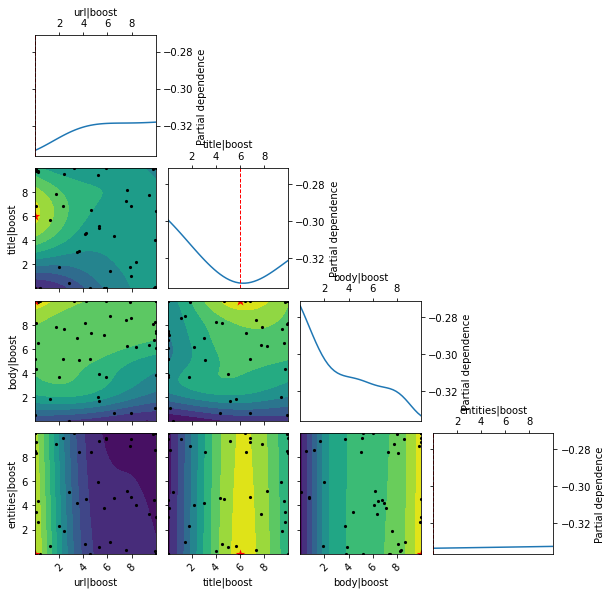

In [50]:
_ = plot_objective(metadata, sample_source='result')

In [51]:
%%time

# optimized over NER queries only
_ = evaluate_mrr100_dev_ner(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3512
CPU times: user 4min 59s, sys: 4.68 s, total: 5min 4s
Wall time: 5min 44s


In [52]:
final_params

{'url|boost': 0.0,
 'title|boost': 5.988332464008273,
 'body|boost': 10.0,
 'entities|boost': 0.0}

In [37]:
%%time

# optimizing over all queries
_ = evaluate_mrr100_dev_ner(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3525
CPU times: user 4min 42s, sys: 3.31 s, total: 4min 46s
Wall time: 5min 22s


In [38]:
final_params

{'url|boost': 0.3019915098610027,
 'title|boost': 2.523830532007498,
 'body|boost': 7.298817737818202,
 'entities|boost': 0.06286157827366302}

In [47]:
%%time

_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
    ]
}
_ = evaluate_mrr100_dev_ner(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0282402606853827,
    'title|boost': 5.620614617420669,
    'body|boost': 9.993215193304582,
})

Evaluation with: MRR@100
Score: 0.3555
CPU times: user 5min 28s, sys: 7.86 s, total: 5min 36s
Wall time: 6min 25s


In [44]:
%%time

_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
    ]
}
_ = evaluate_mrr100_dev_notner(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0282402606853827,
    'title|boost': 5.620614617420669,
    'body|boost': 9.993215193304582,
})

Evaluation with: MRR@100
Score: 0.2623
CPU times: user 5min 23s, sys: 7.76 s, total: 5min 31s
Wall time: 6min 45s


### Base fields + entities + bigrams

In [ ]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "entities^{{entities|boost}}"
    ]
}

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'entities|boost': 1.0
})

In [ ]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 100,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'entities|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

In [ ]:
_ = plot_objective(metadata, sample_source='result')

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

In [ ]:
final_params

In [ ]:
# with 100/20 iterations
# 0.3436

{
    'url|boost': 5.019618907965658,
    'title|boost': 2.1715172653248564,
    'title_bigrams|boost': 0.6258343432390224,
    'body|boost': 8.97005088495938,
    'body_bigrams|boost': 0.785011613141371,
    'expansions|boost': 9.958043226768973,
    'expansions_bigrams|boost': 2.6104666149721205
}

### Selective fields

Based on the results from above, remove fields with `0` boost values.

In [ ]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

In [ ]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 100,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

In [ ]:
_ = plot_objective(metadata, sample_source='result')

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

In [ ]:
final_params

In [ ]:
# with 100/20 iterations
# 0.3405

{
    'url|boost': 5.9772866071225605,
    'body|boost': 10.0,
    'expansions|boost': 10.0,
    'expansions_bigrams|boost': 2.283163846176233
}